In [1]:
import pandas
import numpy
import librosa
import requests
import seaborn
import sklearn
import matplotlib.pyplot as plt

from IPython.display import Image
from random import randrange
from sklearn import preprocessing
from sklearn.tree import export_graphviz
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from subprocess import call
from tqdm import tqdm

In [2]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "mfcc_mean": None,
        "mfcc_var": None,
        "environment": recording["environment"]
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,mfcc_mean,mfcc_var,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,None,None,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,None,None,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,None,None,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,None,None,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,None,None,marsberg


In [3]:
# Function to extract mean and variance of the mfcc
def preprocess(dataframe):
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc_stft = librosa.feature.mfcc(y=audio, sr=sample_rate)
        dataframe.at[index, "mfcc_mean"] = numpy.mean(mfcc_stft)
        dataframe.at[index, "mfcc_var"] = numpy.var(mfcc_stft)
        
    return dataframe

In [4]:
dataframe = preprocess(dataframe)

119it [02:25,  1.22s/it]


In [5]:
# Extract separate dataframes for environments marsberg and duesseldorf
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

In [6]:
# Prepare and split data for training
y = dataframe_marsberg['label']
x = dataframe_marsberg.drop(['label', 'path', 'environment'], axis=1)

cols = x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x)
x = pandas.DataFrame(np_scaled, columns = cols)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [7]:
model = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=0)

model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [8]:
test_predictions = model.predict(x_test)
print(accuracy_score(y_test, test_predictions))

1.0


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

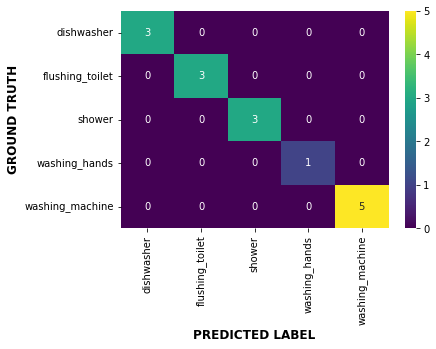

In [9]:
def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'{label}' for label in labels]
    index = [f'{label}' for label in labels]
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    table = pandas.DataFrame(confusion_matrix, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_test, test_predictions)

In [11]:
# Visualise a random estimator from the model
index = randrange(9)
export_graphviz(
    model.estimators_[index],
    out_file='files/tree.dot', 
    feature_names = x.columns,
    class_names = dataframe["label"].unique(),
    rounded = True,
    proportion = False, 
    precision = 2,
    filled = True
)
call(['dot', '-Tpng', 'files/tree.dot', '-o', 'files/tree.png', '-Gdpi=600'])
print(f'Estimator {index + 1} / 10')
Image(filename = 'files/tree.png')

Estimator 5 / 10
